In [1]:
import os, sys
sys.path.insert(1, os.getcwd()) 
sys.path.append("..\\..")
sys.path.append("..")

In [2]:
import numpy as np
from scipy.optimize import nnls
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from fnnls import fnnls

In [3]:
from uilc import PositionArray
from uilc.utils import convolution
from uilc.methods import pw
from uilc.utils import radiation, convolution
from uilc.utils.misc import csym_index

In [4]:
from copy import deepcopy

In [5]:
# https://thepythoncodingbook.com/2021/08/30/2d-fourier-transform-in-python-and-fourier-synthesis-of-images/

def np_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)
def np_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real
def np_2dft_freq(input, pdim):
    Wx, Wy = pdim
    n, m  = input.shape
    return csym_index(n)/Wx, csym_index(m)/Wy

#-------------------------------------------------
def pos_n(i, j, n, m, dx ,dy):
    return (dx*(n-1-i))**2 + (dy*(m-1-j))**2
def get_sym_sol(sol):
    sol1 = sol
    sol2 = np.flip(sol1)
    sol3 = np.flip(sol1, axis =1)
    sol4 = np.flip(sol2, axis =1)
    return (sol1 + sol2 + sol3 + sol4)/4

In [72]:
#Optical system setting
cm = 1E-2
s = 4
alpha = np.array([3, 5]) # W/H
H = 1*cm
W = alpha * H
Wx, Wy = W
print("System parameters:=========")
print("Lambertian:", s)
print("Ratio, x, y:", alpha)
print(f"H:{H}, W:{W}")

System parameters:=========
Lambertian: 4
Ratio, x, y: [3 5]
H:0.01, W:[0.03 0.05]


In [73]:
dr =  W[1]/ W[0]
#n,m = nmax
n = 30
m = int(n * dr)
if m%2 ==0:
    m +1
dx = W[0]/n
dy = W[1]/m
l = 2*n -1
k = 2*m - 1

In [74]:
illum =  np.ones(n*m).reshape(n, m)
illum_v = illum.reshape(n*m)
filter2=np.fromfunction(
    lambda i, j: radiation.lambertian(0, np.sqrt(pos_n(i, j, n, m, dx ,dy)), s, H), 
    (l,k), dtype=float)

In [75]:
A = convolution.get_matrix_system(filter2, (n, m))
A = A/A.max()
dim_l = A.shape[0]
const = np.ones(shape=(dim_l,))
sol = nnls(A, illum_v)[0]
sol_mat= sol.reshape(n,m).transpose()


In [76]:
#---------------------------------------------
sol_f = get_sym_sol(sol.reshape(n,m).transpose())
x_2d, y_2d = np.meshgrid(dx*csym_index(n), dy*csym_index(m))


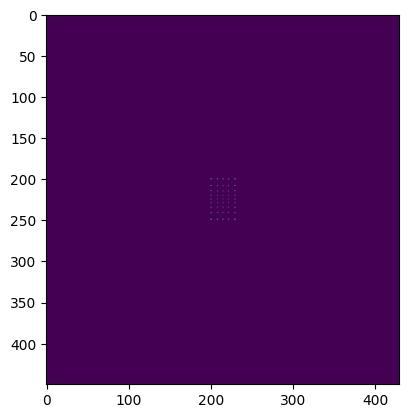

In [77]:
ex_dim = 200
C = np.zeros(shape= (sol_f.shape[0], ex_dim))
R =  np.zeros(shape=( ex_dim, sol_f.shape[1] + 2*ex_dim))
sol_f_ext = np.concatenate([C, sol_f, C], axis=1)
sol_f_ext = np.concatenate([R, sol_f_ext, R], axis=0)

sol_f_fft = np_2dft(sol_f_ext)
f_x, f_y =np_2dft_freq(sol_f, pdim=W)
fx_lim, fy_lim = 2*np.pi/Wx, 2*np.pi/Wy

plt.imshow(sol_f_ext)

In [78]:
dfx = f_x.max() + f_x.min()
dfy = f_y.max() + f_y.min()

f_x += dfx
f_y += dfy

f_lim_x_i =  f_x.max() 
f_lim_x_f =  f_x.min()
f_lim_y_i =  f_y.max() 
f_lim_y_f =  f_y.min()

fre_exent = [f_lim_y_i, f_lim_y_f, f_lim_x_i, f_lim_x_f]

In [79]:
fre_exent

[290.0, -290.0, 816.6666666666667, -816.6666666666667]

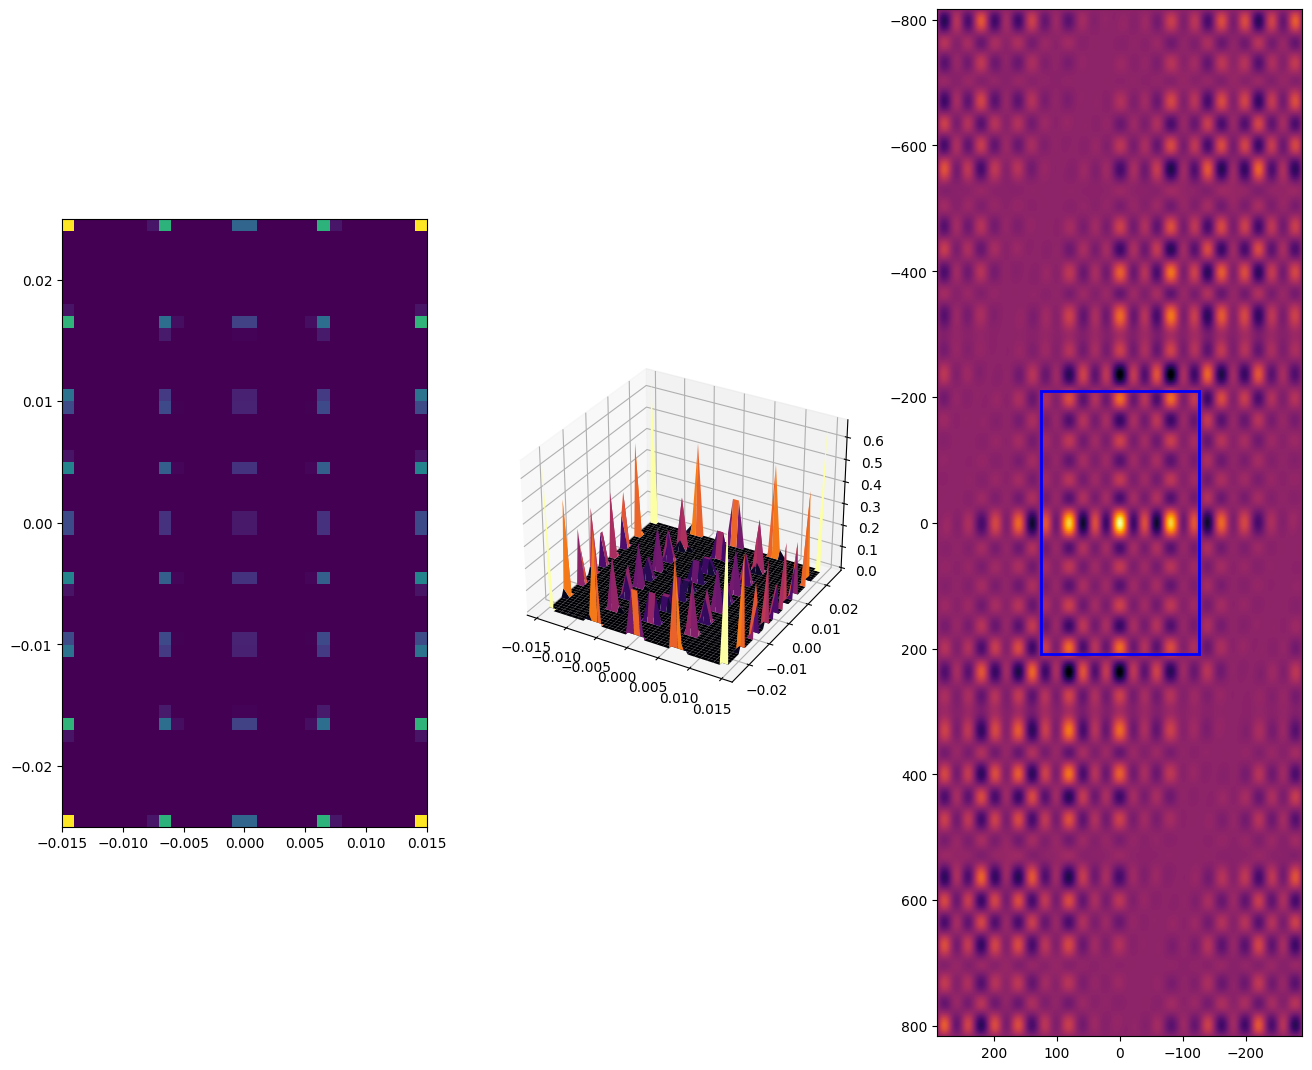

In [80]:
fig = plt.figure(figsize=(16,16))
axis_2d  = fig.add_subplot(1, 3, 1)
axis_3d  = fig.add_subplot(1, 3, 2, projection='3d')
axis_fft = fig.add_subplot(1, 3, 3)

axis_2d.imshow(sol_mat, extent=[-W[0]/2,W[0]/2, -W[1]/2,W[1]/2])

axis_3d.plot_surface(x_2d, y_2d, sol_mat, cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)

axis_fft.imshow(sol_f_fft.real, cmap="inferno", extent = fre_exent)

axis_fft.add_patch(Rectangle((-fy_lim,-fx_lim), 2*fy_lim, 2*fx_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2,
                    linewidth=20))
plt.show()

In [81]:
fx_lim, fy_lim

(209.43951023931956, 125.66370614359172)

In [82]:
sol_f_fft_real = deepcopy(sol_f_fft.real)

In [83]:
fx_lim_edge = f_x.max()
fy_lim_edge = f_y.max()

n_ext, m_ext = sol_f_fft.real.shape

In [84]:
f_x_line = np.linspace(-fx_lim_edge, fx_lim_edge, n_ext, endpoint=True)
f_y_line = np.linspace(-fy_lim_edge, fy_lim_edge, m_ext, endpoint=True)

In [85]:
fy_2d, fx_2d = np.meshgrid(f_y_line , f_x_line)

In [86]:
f_x_line.max()

816.6666666666667

In [87]:
n_max_fx = np.where(f_x_line < -fx_lim)[0].max() if f_x_line.min() < -fx_lim else 0

n_max_fy = np.where(f_y_line < -fy_lim)[0].max() if f_y_line.min() < -fy_lim else 0

In [88]:
if n_max_fx != 0:
    sol_f_fft_real[:n_max_fx] = 0
    sol_f_fft_real[-n_max_fx:] = 0
if n_max_fy != 0:
    sol_f_fft_real[:,   :n_max_fy ] = 0
    sol_f_fft_real[:, - n_max_fy: ] = 0

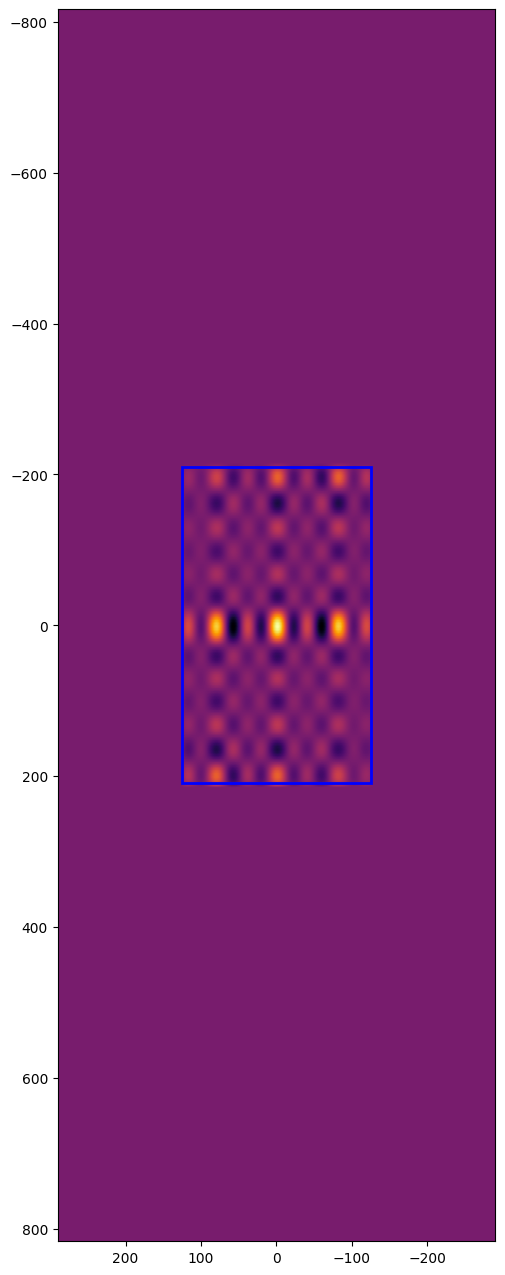

In [89]:
fig = plt.figure(figsize=(16,16))
axis_fft  = fig.add_subplot(1, 1, 1)
axis_fft.imshow(sol_f_fft_real, cmap="inferno", extent = fre_exent)
axis_fft.add_patch(Rectangle((-fy_lim,-fx_lim), 2*fy_lim, 2*fx_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2,
                    linewidth=20))

In [90]:
sol_blur = np_2dift(sol_f_fft_real)

In [91]:
sol_blur = sol_blur[:, ex_dim:]
sol_blur = sol_blur[:, :-ex_dim]
sol_blur = sol_blur[ex_dim:]
sol_row_n = sol_blur.shape[0] - ex_dim
sol_b = sol_blur[:sol_row_n]

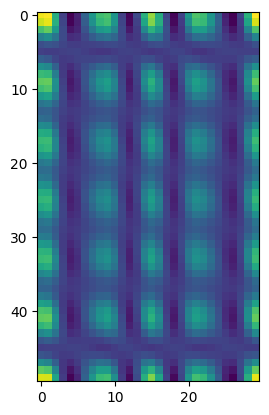

In [92]:
plt.imshow(sol_b)

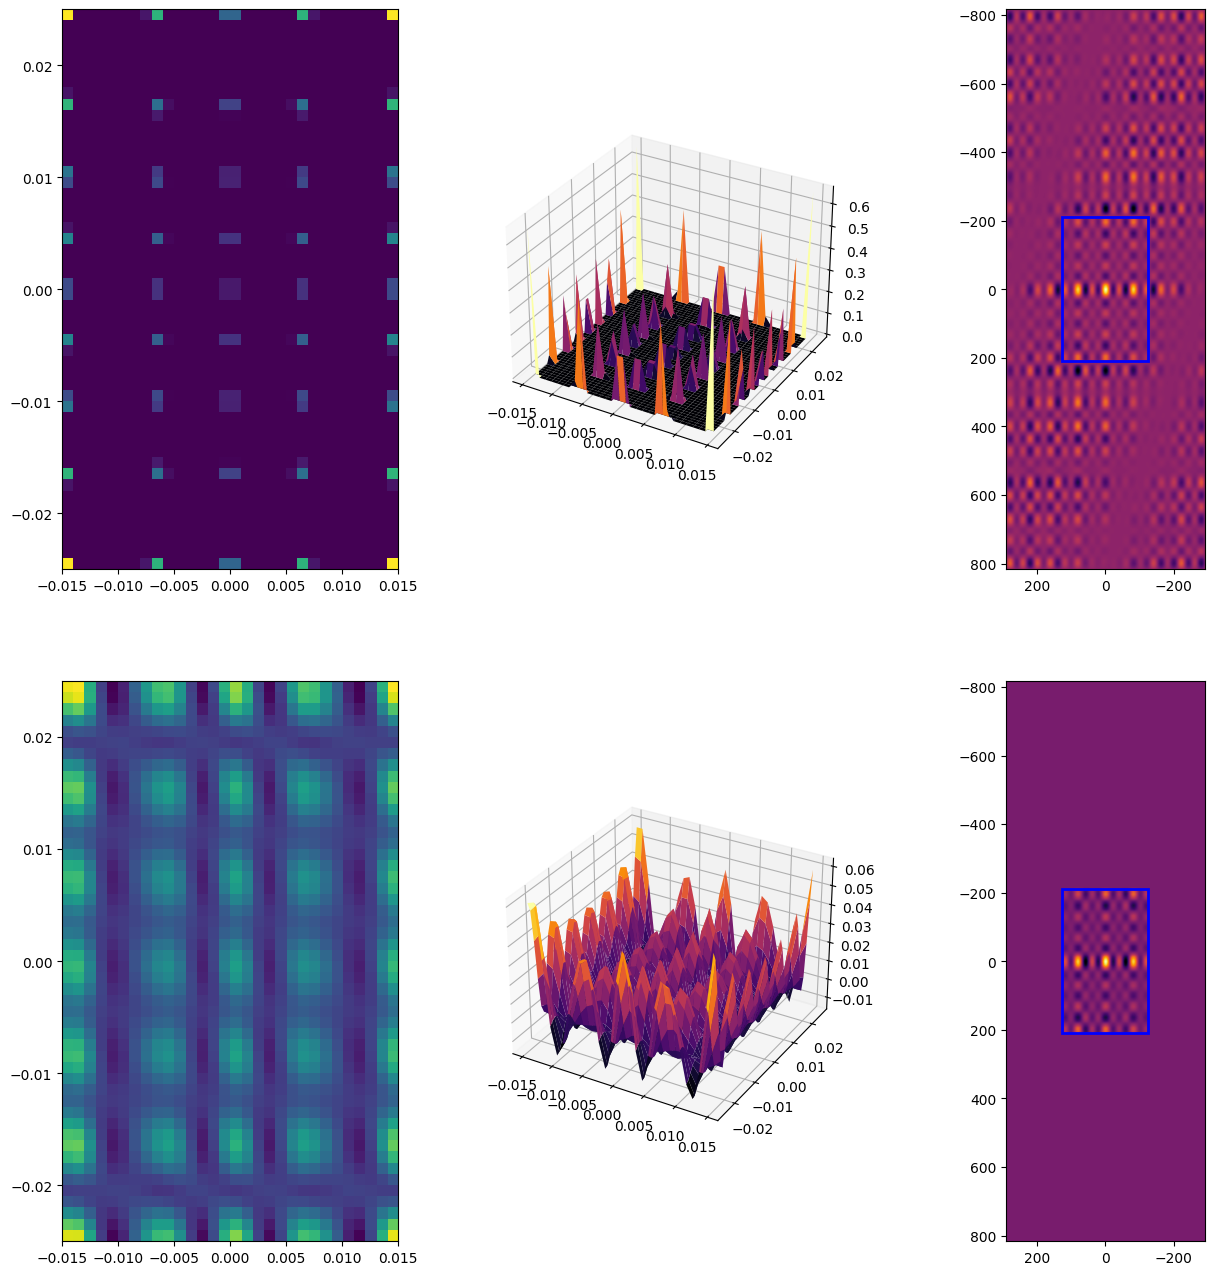

In [93]:
fig = plt.figure(figsize=(16,16))
axis_2d  = fig.add_subplot(2, 3, 1)
axis_3d  = fig.add_subplot(2, 3, 2, projection='3d')
axis_fft = fig.add_subplot(2, 3, 3)

axis_low_2d = fig.add_subplot(2, 3, 4)
axis_low_3d  = fig.add_subplot(2, 3, 5, projection='3d')
axis_low_fft = fig.add_subplot(2, 3, 6)

axis_2d.imshow(sol_mat, extent=[-W[0]/2,W[0]/2, -W[1]/2,W[1]/2])
axis_low_2d.imshow(sol_b, extent=[-W[0]/2,W[0]/2, -W[1]/2,W[1]/2])

axis_3d.plot_surface(x_2d, y_2d, sol_mat, cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)
axis_low_3d.plot_surface(x_2d, y_2d, sol_b, cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)

axis_fft.imshow(sol_f_fft.real, cmap="inferno", extent = fre_exent)
axis_low_fft.imshow(sol_f_fft_real, cmap="inferno", extent = fre_exent)

axis_fft.add_patch(Rectangle((-fy_lim,-fx_lim), 2*fy_lim, 2*fx_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2,
                    linewidth=20))
axis_low_fft.add_patch(Rectangle((-fy_lim,-fx_lim), 2*fy_lim, 2*fx_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2,
                    linewidth=20))

plt.show()

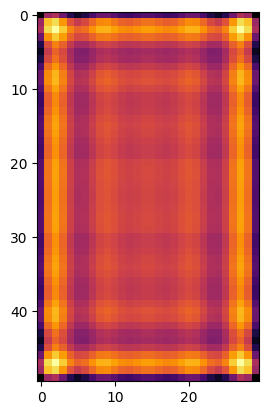

In [125]:
low_test = convolution.convolve2d(sol_mat , filter2,image_mode=True)
plt.imshow(low_test, cmap ='inferno')

In [126]:
low_test /= low_test.max()
print(low_test.min())
print(low_test.std())
print(low_test.mean())

0.9325082085214501
0.010154781379671438
0.96950863537087


---

In [94]:
# X direction
weights_x, position_x = pw.power_weight(s, W[0], H, dim =n ,set_nmax = False)
# Y direction
weights_y, position_y = pw.power_weight(s, W[1], H, dim =m ,set_nmax = False)
wx = (weights_x+ np.flip(weights_x))/2
wy = (weights_y+ np.flip(weights_y))/2

In [95]:
sol_conv = convolution.convolve2d(wx.reshape(1, -1), wy.reshape(-1, 1)).transpose()
sol_conv /= sol_conv.max()

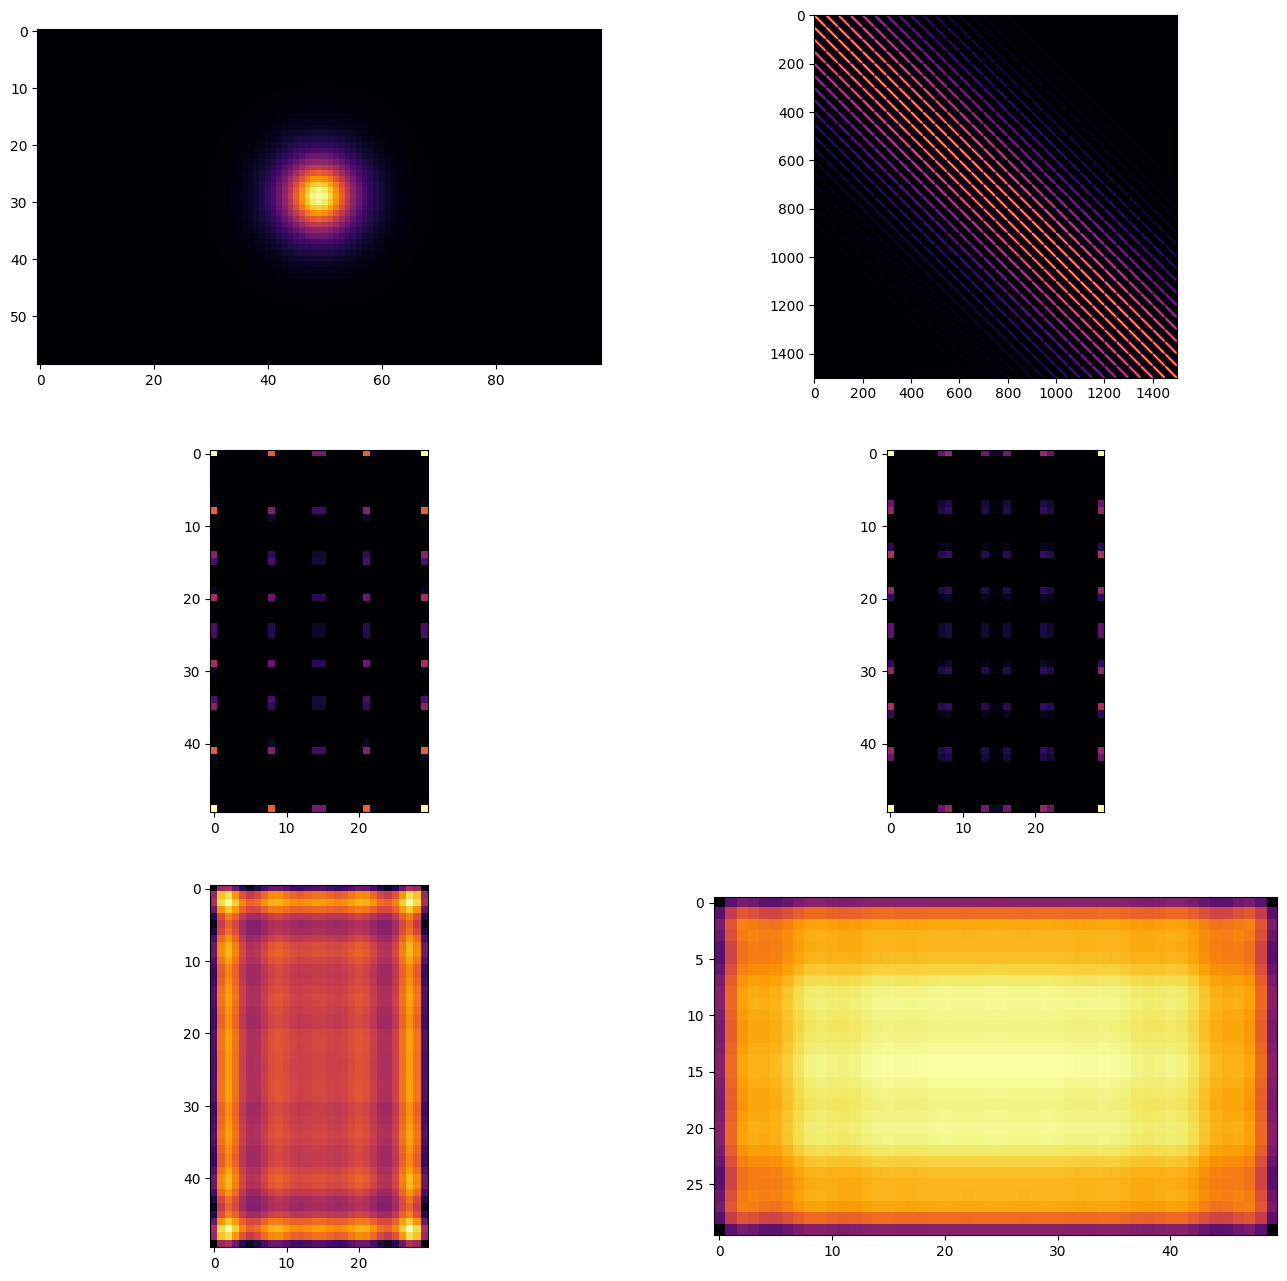

In [96]:
fig =plt.figure(figsize=(16,16))

axes = [
    fig.add_subplot(3,2 ,1),
    fig.add_subplot(3,2 ,2),
    fig.add_subplot(3,2 ,3),
    fig.add_subplot(3,2 ,4),
    fig.add_subplot(3,2 ,5),
    fig.add_subplot(3,2 ,6),
    ]

axes[0].imshow(filter2, cmap ='inferno')
axes[1].imshow(A, cmap ='inferno')
axes[2].imshow(sol_f/sol_f.max(), cmap ='inferno')
axes[3].imshow((sol_conv/sol_conv.max()).transpose(), cmap ='inferno')
axes[4].imshow(convolution.convolve2d(sol_f , filter2,image_mode=True), cmap ='inferno')
axes[5].imshow(convolution.convolve2d(sol_conv , filter2,image_mode=True), cmap ='inferno')
plt.show()

In [97]:
sol_f_fft = np_2dft(sol_f)
f_x, f_y =np_2dft_freq(sol_f, pdim=W)
sol_conv_fft = np_2dft(sol_conv)
f_x2, f_y2 =np_2dft_freq(sol_conv, pdim=W)

In [98]:
Wx, Wy = W
fx_lim, fy_lim = 2*np.pi/Wx, 2*np.pi/Wy

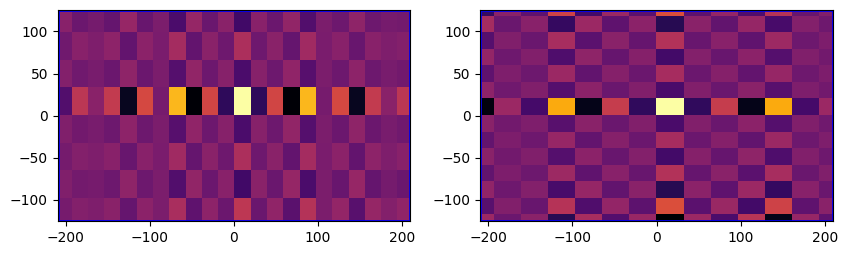

In [99]:
fig =plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(sol_f_fft.real, cmap="inferno", extent=[-f_y.max(),f_y.max(),f_x.max(),-f_x.max()])
ax1.add_patch(Rectangle((-fx_lim,-fy_lim), 2*fx_lim, 2*fy_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2))
ax2.imshow(sol_conv_fft.real.transpose(), cmap="inferno", extent=[-f_x2.max(),f_x2.max(),f_y2.max(),-f_y2.max()])
ax2.add_patch(Rectangle((-fx_lim,-fy_lim), 2*fx_lim, 2*fy_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2))
ax1.set_xlim([-fx_lim, fx_lim])
ax2.set_xlim([-fx_lim, fx_lim])
ax1.set_ylim([-fy_lim, fy_lim])
ax2.set_ylim([-fy_lim, fy_lim])
plt.show()

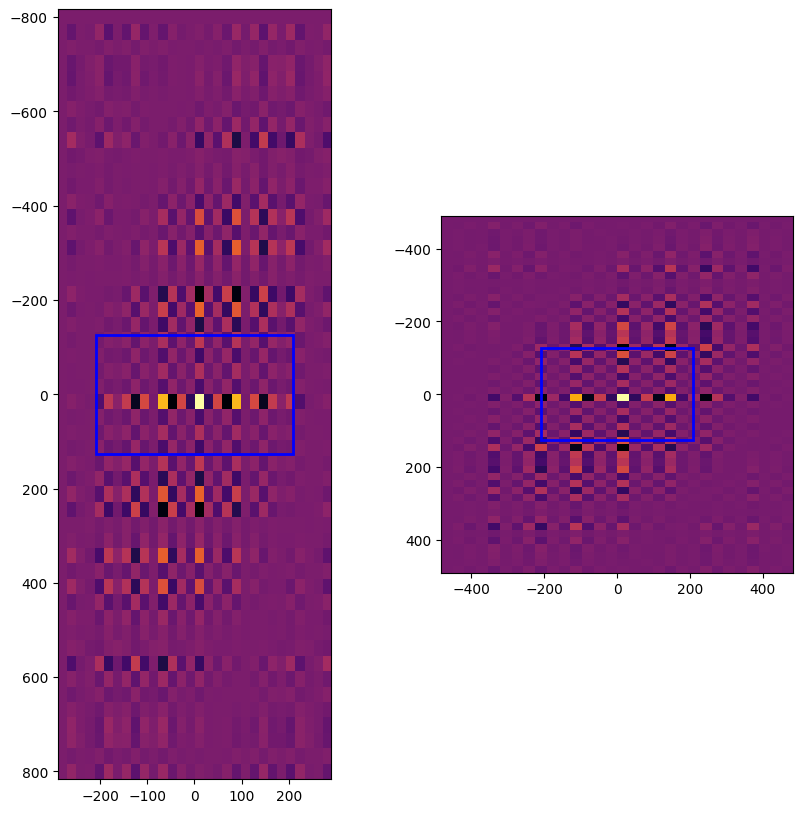

In [100]:
fig =plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(sol_f_fft.real, cmap="inferno", extent=[-f_y.max(),f_y.max(),f_x.max(),-f_x.max()])
ax1.add_patch(Rectangle((-fx_lim,-fy_lim), 2*fx_lim, 2*fy_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2))
ax2.imshow(sol_conv_fft.real.transpose(), cmap="inferno", extent=[-f_x2.max(),f_x2.max(),f_y2.max(),-f_y2.max()])
ax2.add_patch(Rectangle((-fx_lim,-fy_lim), 2*fx_lim, 2*fy_lim,
                    edgecolor='blue',
                    facecolor='none',
                    lw=2))
plt.show()

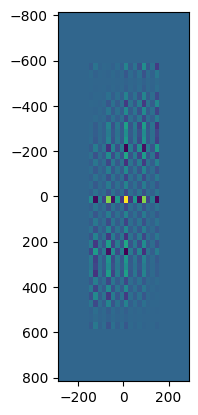

In [101]:
sol = sol_conv_fft.real.transpose()
r = 7
c = 7
sol[:r] = 0
sol[-r:] = 0
sol[:, :c] = 0
sol[:, -c:] = 0
plt.imshow(sol, extent=[-f_y.max(),f_y.max(),f_x.max(),-f_x.max()])

In [102]:
sol_x = np_2dift(sol_conv_fft.real)

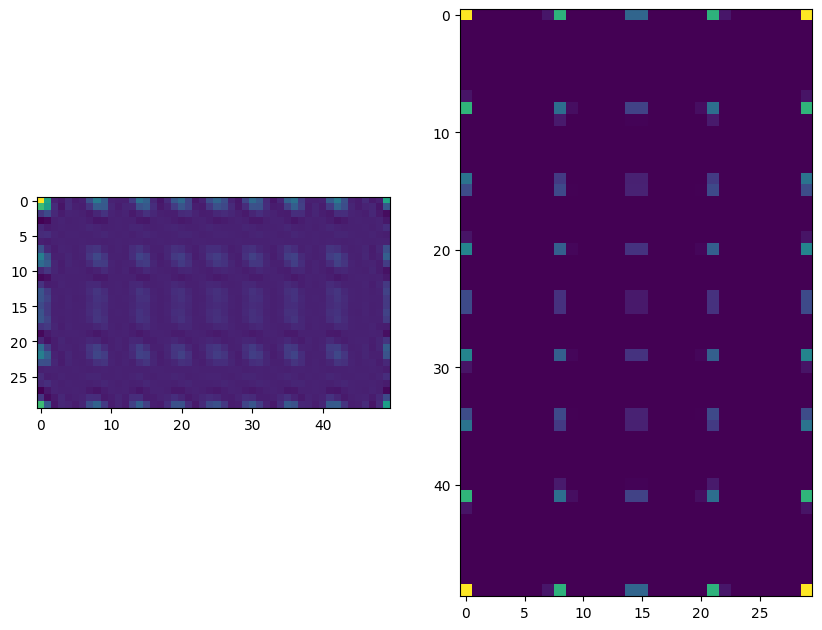

In [103]:
fig =plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sol_low = get_sym_sol(np_2dift(sol).real)
ax1.imshow(sol_x)
ax2.imshow(sol_f)

In [104]:
sol_low.min()

-0.0357688257460476

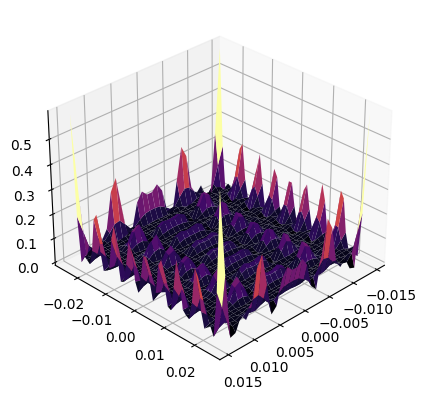

In [106]:
x_2d, y_2d = np.meshgrid(dx*csym_index(n), dy*csym_index(m))
z = sol_low.transpose()
z -= z.min()
fig, axis = plt.subplots(1,1, subplot_kw={"projection":'3d'})
axis.view_init(elev=30, azim=45, roll=0)
axis.plot_surface(x_2d, y_2d, z.transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)

<Figure size 1000x1000 with 0 Axes>

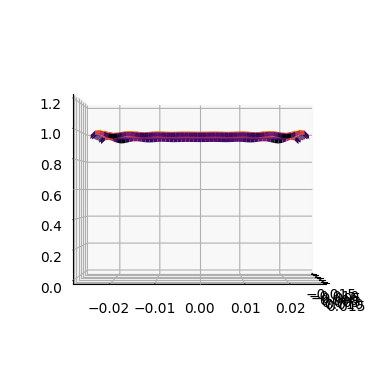

In [108]:
z_3d = convolution.convolve2d(sol_f.transpose(), filter2, image_mode = True)
z_3d /= z_3d.max()
fig =plt.figure(figsize=(10,10))
fig, axis = plt.subplots(1,1, subplot_kw={"projection":'3d'})
axis.plot_surface(x_2d, y_2d, z_3d.transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)
axis.set_zlim(0, 1.2)
axis.view_init(elev=0, azim=0, roll=0)
plt.show()


In [109]:
z_3d.min()

0.9323107170610504

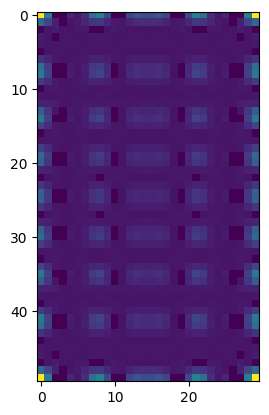

In [110]:
t_z = z.transpose()
t_z /= t_z.max()
ma =np.max(t_z)
cutting = np.where(t_z < 0.05*ma, 0, t_z)
plt.imshow(cutting)

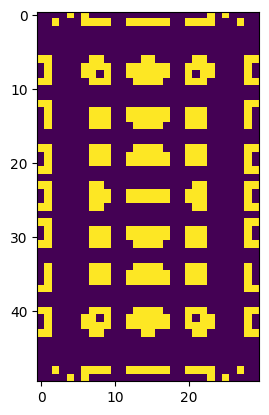

In [111]:
cutting1 = np.where(t_z <= 0.2*ma, t_z, 0)
cutting2 = np.where(cutting1 < 0.08*ma, 0, 0.6)
plt.imshow(cutting2)

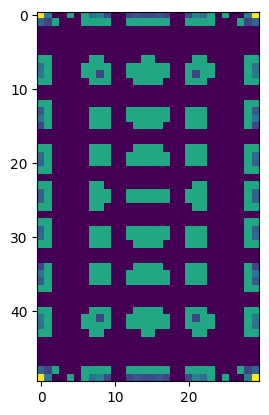

In [112]:
plt.imshow(t_z - cutting1 + cutting2)

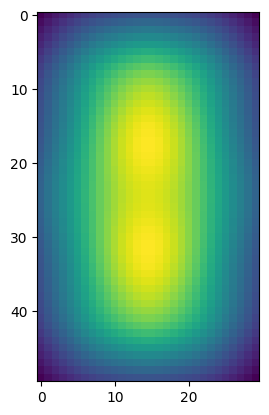

In [113]:
plt.imshow(convolution.convolve2d(t_z - cutting1 + cutting2, filter2, image_mode = True))

In [114]:
dim = sol_f_fft.shape
f_x, f_y =np_2dft_freq(sol_f, pdim=W)
X_2d, Y_2d = np.meshgrid(f_x, f_y)

c:\Users\qwqwh\anaconda3\envs\uilc\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


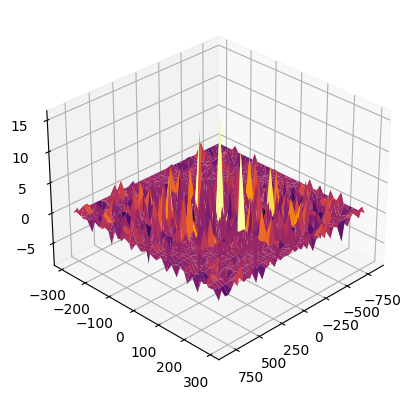

In [115]:
fig, axis = plt.subplots(1,1, subplot_kw={"projection":'3d'})
axis.view_init(elev=30, azim=45, roll=0)
axis.plot_surface(X_2d, Y_2d, sol_f_fft.transpose(), cmap='inferno',
                       linewidth=2, antialiased=True, shade=True)

In [116]:
f_x

array([-816.66666667, -783.33333333, -750.        , -716.66666667,
       -683.33333333, -650.        , -616.66666667, -583.33333333,
       -550.        , -516.66666667, -483.33333333, -450.        ,
       -416.66666667, -383.33333333, -350.        , -316.66666667,
       -283.33333333, -250.        , -216.66666667, -183.33333333,
       -150.        , -116.66666667,  -83.33333333,  -50.        ,
        -16.66666667,   16.66666667,   50.        ,   83.33333333,
        116.66666667,  150.        ,  183.33333333,  216.66666667,
        250.        ,  283.33333333,  316.66666667,  350.        ,
        383.33333333,  416.66666667,  450.        ,  483.33333333,
        516.66666667,  550.        ,  583.33333333,  616.66666667,
        650.        ,  683.33333333,  716.66666667,  750.        ,
        783.33333333,  816.66666667])

---

In [117]:
from scipy import special
from matplotlib import pyplot as plt
import numpy as np

In [118]:
x = np.linspace(-30, 30, 600)
param = [2*i+1 for i in range(0, 3)]
legends = [f"{p}" for p in param]
ys = [special.diric(x, p) for p in param]

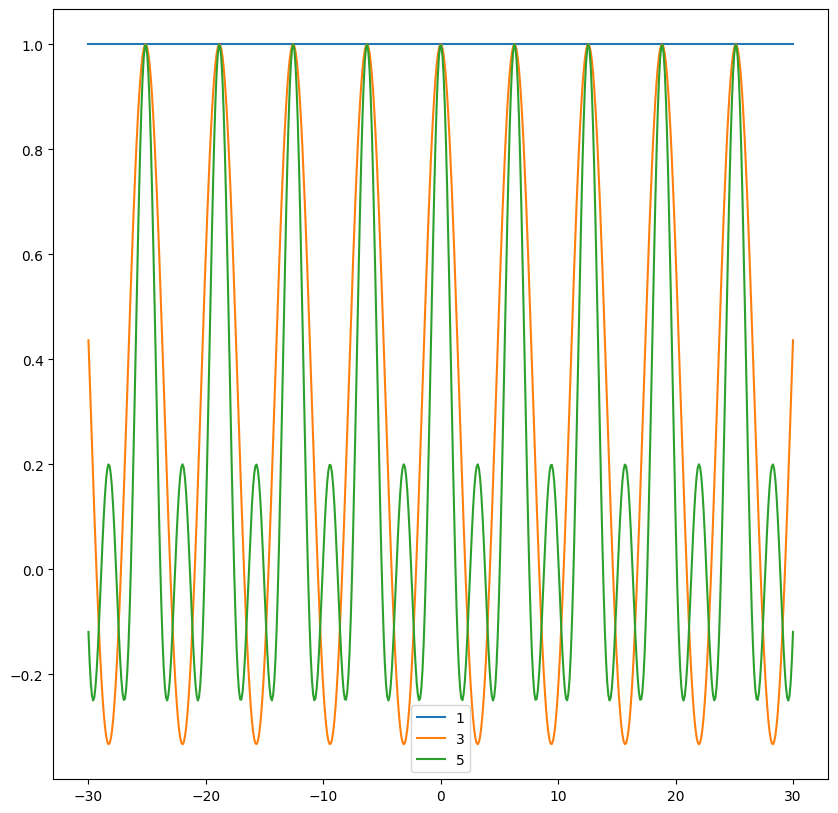

In [119]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
for y in ys:
    ax.plot(x, y)
ax.legend(legends)
plt.show()